## test codes

In [2]:
import os
import sys

In [5]:
condapath = sys.executable
print(condapath)

C:\Users\KISTI\Anaconda3\envs\ai\python.exe


In [12]:
os.environ

environ{'ALLUSERSPROFILE': 'C:\\ProgramData',
        'ANSYS191_DIR': 'C:\\Program Files\\ANSYS Inc\\v191\\ANSYS',
        'ANSYSLIC_DIR': 'C:\\Program Files\\ANSYS Inc\\Shared Files\\Licensing',
        'ANSYS_SYSDIR': 'winx64',
        'ANSYS_SYSDIR32': 'win32',
        'ANS_OLD_ATTACH': '1',
        'APPDATA': 'C:\\Users\\KISTI\\AppData\\Roaming',
        'APR_ICONV_PATH': 'C:\\AutoSet9\\Server\\bin\\iconv\\',
        'AWP_LOCALE191': 'en-us',
        'AWP_ROOT191': 'C:\\Program Files\\ANSYS Inc\\v191',
        'CADOE_LIBDIR191': 'C:\\Program Files\\ANSYS Inc\\v191\\CommonFiles\\Language\\en-us',
        'CLASSPATH': 'C:\\Program Files\\Java\\jdk1.8.0_111\\lib;.',
        'COMMONPROGRAMFILES': 'C:\\Program Files\\Common Files',
        'COMMONPROGRAMFILES(X86)': 'C:\\Program Files (x86)\\Common Files',
        'COMMONPROGRAMW6432': 'C:\\Program Files\\Common Files',
        'COMPUTERNAME': 'K0878P1',
        'COMSPEC': 'C:\\WINDOWS\\system32\\cmd.exe',
        'CUDA_PATH': 'C:\\Prog

In [11]:
%%writefile ./train.py

print("hello world")

Writing ./train.py


## start template code

# MNIST DataSet
dataset download(.gz file) by request

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

assign MNIST numpy array dataset using `pickle` library

In [14]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

Each image is 28 x 28, and is being stored as a flattened row of length
784 (=28x28). Let's take a look at one; we need to reshape it to 2d
first.

(50000, 784)


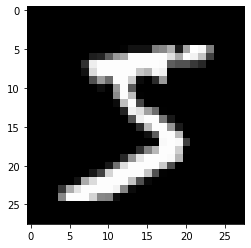

In [15]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

good to see the first MNIST hand written data

PyTorch uses ``torch.tensor``, rather than numpy arrays, so we need to
convert our data.



In [18]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape

C:\Users\KISTI\Anaconda3\envs\ai\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor(0),
 tensor(9))

print to verify Pytorch Tensors

In [19]:
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


### define loss function and output function

In [33]:
import torch.nn.functional as F

loss_func = F.cross_entropy

### Make Deep Nueral Netword(DNN)

In [21]:
from torch import nn

# Logistic model using Parameter
'''
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias
'''
# Logistic model using Linear
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

### hyperparameters settings

In [25]:
bs = 64  # batch size
lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

### use optim library

In [23]:
from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

### use DataLoader and TensorDataset

In [31]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

### loss function and batch

In [28]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

# `fit` method

In [29]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

zip
`zip(*iterable)`은 동일한 개수로 이루어진 자료형을 묶어 주는 역할을 하는 함수이다.

※ 여기서 사용한 `*iterable`은 반복 가능(iterable)한 자료형 여러 개를 입력할 수 있다는 의미이다.

아래 예시 참조

In [14]:
print(list(zip([1, 2, 3], [4, 5, 6])))
print(list(zip([1, 2, 3], [4, 5, 6], [7, 8, 9])))
a,b,c = zip([1, 2, 3], [4, 5, 6], [7, 8, 9])
print(a,b,c)
print(type(a))
print(list(zip("abc", "def")))

[(1, 4), (2, 5), (3, 6)]
[(1, 4, 7), (2, 5, 8), (3, 6, 9)]
(1, 4, 7) (2, 5, 8) (3, 6, 9)
<class 'tuple'>
[('a', 'd'), ('b', 'e'), ('c', 'f')]


# getting data and model fitting

In [34]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3579676120758057
1 0.48495064752101896


# Make Python file to run

In [9]:
%%writefile ./train.py

from pathlib import Path
import argparse
import requests
import pickle
import gzip
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Logistic model using Linear
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

        
# Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=42, metavar='S',
                    help='random seed (default: 42)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--fp16-allreduce', action='store_true', default=False,
                    help='use fp16 compression during allreduce')
parser.add_argument('--use-adasum', action='store_true', default=False,
                    help='use adasum algorithm to do reduction')
args = parser.parse_args()

############### Load Dataset ###############
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

############### Mapping PyTorch Tensors ###############
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

############### Define Loss Function ###############
loss_func = F.cross_entropy        

############### HyperParameters ###############
# bs = 64  # batch size
batch_size = args.batch_size # from arguments
test_batch_size = args.test_batch_size
# lr = 0.5  # learning rate
lr = args.lr # from arguments
# epochs = 2  # how many epochs to train for
epochs = args.epochs # from arguments

############### Setting Data ###############
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)

############### Getting Model ###############
model, opt = get_model()

############### Training Model ###############
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Overwriting ./train.py


## Test Code (Fixed Arguments)

In [10]:
%%writefile ./train_test.py

from pathlib import Path
import requests
import pickle
import gzip
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Logistic model using Linear
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

############### Load Dataset ###############
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

############### Mapping PyTorch Tensors ###############
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

############### Define Loss Function ###############
loss_func = F.cross_entropy        

############### HyperParameters ###############
batch_size = 64
test_batch_size = 128
lr = 0.1  # learning rate
epochs = 10  # how many epochs to train for


############### Setting Data ###############
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)

############### Getting Model ###############
model, opt = get_model()

############### Training Model ###############
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Overwriting ./train_test.py


### Modified Version Below

In [23]:
# %%writefile ./train_test.py

from pathlib import Path
import requests
import pickle
import gzip
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Logistic model using Linear
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        losses = []
        nums = []
        accuracies = 0.
        for xb, yb in train_dl:
            model.train()
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            model.eval()
            losses.append(loss.item())
            nums.append(len(xb))
            acc = accuracy(preds, yb)
            accuracies += acc*len(xb)
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)        
        val_acc = accuracies / np.sum(nums)           
        print("Epoch: {:d}, Loss: {:f}, Accuracy: {:f}".format(epoch+1, val_loss, val_acc*100))

############### Load Dataset ###############
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

############### Mapping PyTorch Tensors ###############
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

############### Define Loss Function ###############
loss_func = F.cross_entropy        

############### HyperParameters ###############
batch_size = 64
test_batch_size = 128
lr = 0.2  # learning rate
epochs = 100  # how many epochs to train for


############### Setting Data ###############
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)

############### Getting Model ###############
model, opt = get_model()

############### Training Model ###############
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Epoch: 1, Loss: 0.435265, Accuracy: 88.195999
Epoch: 2, Loss: 0.323936, Accuracy: 90.991997
Epoch: 3, Loss: 0.305298, Accuracy: 91.324005
Epoch: 4, Loss: 0.294997, Accuracy: 91.725998
Epoch: 5, Loss: 0.288776, Accuracy: 91.931999
Epoch: 6, Loss: 0.283973, Accuracy: 92.005997
Epoch: 7, Loss: 0.280601, Accuracy: 92.118004
Epoch: 8, Loss: 0.276476, Accuracy: 92.276001
Epoch: 9, Loss: 0.275013, Accuracy: 92.356003
Epoch: 10, Loss: 0.272137, Accuracy: 92.362000
Epoch: 11, Loss: 0.270319, Accuracy: 92.419998
Epoch: 12, Loss: 0.269036, Accuracy: 92.445999
Epoch: 13, Loss: 0.267302, Accuracy: 92.515999
Epoch: 14, Loss: 0.265623, Accuracy: 92.538002
Epoch: 15, Loss: 0.264390, Accuracy: 92.585999
Epoch: 16, Loss: 0.263262, Accuracy: 92.695999
Epoch: 17, Loss: 0.262047, Accuracy: 92.598000
Epoch: 18, Loss: 0.261711, Accuracy: 92.646004
Epoch: 19, Loss: 0.260219, Accuracy: 92.722000
Epoch: 20, Loss: 0.259152, Accuracy: 92.643997
Epoch: 21, Loss: 0.258789, Accuracy: 92.765999
Epoch: 22, Loss: 0.257